In [1]:
# create pair trade strategy based on cointegration and backtest
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm
from statsmodels.regression.linear_model import OLS

In [2]:
#download price data from yahoo finance
#import libraries from yahoo finance
from yahooquery import Ticker

#list of stock in SET50 index
stock_list = ['ADVANC.bk', 'AOT.bk', 'AWC.bk', 'BANPU.bk', 'BBL.bk', 'BDMS.bk', 'BEM.bk', 'BGRIM.bk', 'BH.bk', 'BTS.bk', 'CBG.bk', 'CENTEL.bk', 'COM7.bk', 'CPALL.bk', 'CPF.bk', 'CPN.bk', 'CRC.bk', 'DELTA.bk', 'EA.bk', 'EGCO.bk', 'GLOBAL.bk', 'GPSC.bk', 'GULF.bk', 'HMPRO.bk', 'INTUCH.bk', 'IVL.bk', 'JMART.bk', 'JMT.bk', 'KBANK.bk', 'KTB.bk', 'KTC.bk', 'LH.bk', 'MINT.bk', 'MTC.bk', 'OR.bk', 'OSP.bk', 'PTT.bk', 'PTTEP.bk', 'PTTGC.bk', 'RATCH.bk', 'SAWAD.bk', 'SCB.bk', 'SCC.bk', 'SCGP.bk', 'TIDLOR.bk', 'TISCO.bk', 'TOP.bk', 'TRUE.bk', 'TTB.bk', 'TU.bk']
# stock_list = ['msft', 'aapl', 'meta', 'goog', 'amzn', 'nvda']

all_symbols = " ".join(stock_list)
myInfo = Ticker(all_symbols)
myDict = myInfo.price

for ticker in stock_list:
    ticker = str(ticker)
    longName = myDict[ticker]['longName']
    market_cap = myDict[ticker]['marketCap']
    price = myDict[ticker]['regularMarketPrice']
    print(ticker, longName, market_cap, price)


ADVANC.bk Advanced Info Service Public Company Limited 636436021248 214.0
AOT.bk Airports of Thailand Public Company Limited 1028570415104 72.0
AWC.bk Asset World Corp Public Company Limited 160075759616 4.94
BANPU.bk Banpu Public Company Limited 74819321856 8.85
BBL.bk Bangkok Bank Public Company Limited 304459972608 159.5
BDMS.bk Bangkok Dusit Medical Services Public Company Limited 441002983424 27.75
BEM.bk Bangkok Expressway and Metro Public Company Limited 130686754816 8.55
BGRIM.bk B.Grimm Power Public Company Limited 90589773824 34.75
BH.bk Bumrungrad Hospital Public Company Limited 179644235776 226.0
BTS.bk BTS Group Holdings Public Company Limited 98098618368 7.45
CBG.bk Carabao Group Public Company Limited 65500000256 65.5
CENTEL.bk Central Plaza Hotel Public Company Limited 67908558848 49.5
COM7.bk Com7 Public Company Limited 63202496512 26.5
CPALL.bk CP ALL Public Company Limited 561437474816 62.5
CPF.bk Charoen Pokphand Foods Public Company Limited 153128501248 19.7
CPN.bk

In [3]:
# download all stock price from yahoo finance
start = '2020-01-01'
end = '2022-12-31'
df_price = myInfo.history(start=start, end=end)

In [4]:
df_price

open        high         low       close  \
symbol    date                                                         
ADVANC.bk 2020-01-02  214.000000  219.000000  212.000000  218.000000   
          2020-01-03  216.000000  217.000000  215.000000  216.000000   
          2020-01-06  216.000000  220.000000  216.000000  217.000000   
          2020-01-07  218.000000  224.000000  217.000000  223.000000   
          2020-01-08  221.000000  223.000000  219.000000  220.000000   
...                          ...         ...         ...         ...   
TU.bk     2022-12-26   16.700001   16.700001   16.600000   16.600000   
          2022-12-27   16.700001   16.799999   16.600000   16.799999   
          2022-12-28   16.700001   16.799999   16.600000   16.700001   
          2022-12-29   16.700001   17.000000   16.700001   16.900000   
          2022-12-30   16.900000   16.900000   16.700001   16.900000   

                          volume    adjclose  dividends  splits  
symbol    date                                                   
ADVANC.bk 2020-01-02   5921300.0  191.461044        0.0     0.0  
          2020-01-03   4426800.0  189.704483        0.0     0.0  
          2020-01-06   5147100.0  190.582764        0.0     0.0  
          2020-01-07   7220900.0  195.852325        0.0     0.0  
          2020-01-08   6768300.0  193.217529        0.0     0.0  
...                          ...         ...        ...     ...  
TU.bk     2022-12-26   7975400.0   16.140629        0.0     0.0  
          2022-12-27   6724800.0   16.335094        0.0     0.0  
          2022-12-28  10205600.0   16.237862        0.0     0.0  
          2022-12-29  15184100.0   16.432327        0.0     0.0  
          2022-12-30  12140300.0   16.432327        0.0     0.0  

[34864 rows x 8 columns]

In [5]:
df_price = df_price.reset_index()[['symbol', 'date', 'adjclose']]
#remove .bk from symbol
df_price['symbol'] = df_price['symbol'].str.replace('.bk', '')
df_price

,symbol,date,adjclose
0,ADVANC,2020-01-02,191.461044
1,ADVANC,2020-01-03,189.704483
2,ADVANC,2020-01-06,190.582764
3,ADVANC,2020-01-07,195.852325
4,ADVANC,2020-01-08,193.217529
...,...,...,...
34859,TU,2022-12-26,16.140629
34860,TU,2022-12-27,16.335094
34861,TU,2022-12-28,16.237862
34862,TU,2022-12-29,16.432327


In [6]:
df_price.to_parquet('../data/price.parquet')

In [7]:
df_price = pd.read_parquet('../data/price.parquet')

In [8]:
df_price = df_price.pivot(index='date', columns='symbol', values='adjclose')
df_price

symbol,ADVANC,AOT,AWC,BANPU,BBL,BDMS,BEM,BGRIM,BH,BTS,...,SAWAD,SCB,SCC,SCGP,TIDLOR,TISCO,TOP,TRUE,TTB,TU
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,191.461044,74.814011,5.626850,9.423205,144.989517,24.252909,10.319876,51.481392,133.183640,11.812447,...,58.312538,NaN,344.956329,NaN,NaN,73.624092,61.756592,4.293668,1.455010,11.541586
2020-01-03,189.704483,73.571259,5.577491,9.501082,142.329163,23.328989,10.414555,50.995716,128.638138,11.724295,...,58.526917,NaN,338.796417,NaN,NaN,73.986778,62.626392,4.256332,1.446350,11.796180
2020-01-06,190.582764,71.831390,5.429417,8.955940,138.338638,23.328989,10.319876,50.995716,125.910789,11.547989,...,57.454998,NaN,327.356537,NaN,NaN,72.898727,60.886776,4.088319,1.377063,11.202127
2020-01-07,195.852325,73.322701,5.577491,9.033819,138.782028,23.559969,10.698588,52.209904,128.638138,11.900599,...,60.241985,NaN,332.636505,NaN,NaN,73.261414,60.886776,4.088319,1.377063,11.456722
2020-01-08,193.217529,72.577049,5.478775,8.644428,135.678253,23.328989,10.603910,50.752884,127.729012,11.812447,...,59.598839,NaN,321.196594,NaN,NaN,72.898727,58.494797,3.920306,1.333759,11.286991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,188.123428,73.750000,6.015735,12.571100,142.746048,27.950001,9.525484,39.463856,205.726517,8.156070,...,45.959457,99.359192,332.873016,55.079998,25.680712,91.538849,54.065109,4.740000,1.310290,16.140629
2022-12-27,189.593140,75.500000,6.214602,12.477981,143.727127,28.197346,9.673549,39.214085,208.693726,8.254335,...,46.927029,100.309998,337.841278,56.072430,25.680712,91.769424,54.549999,4.780000,1.319924,16.335094
2022-12-28,190.083054,75.500000,6.264319,12.757339,144.217667,28.692036,9.624193,39.713627,210.671860,8.303468,...,47.652702,100.785400,338.834930,56.320541,25.900204,92.000000,54.307556,4.780000,1.329559,16.237862


In [18]:
# df_price.to_excel('../data/price_pivot.xlsx', index=True, header=True)

<Axes: >

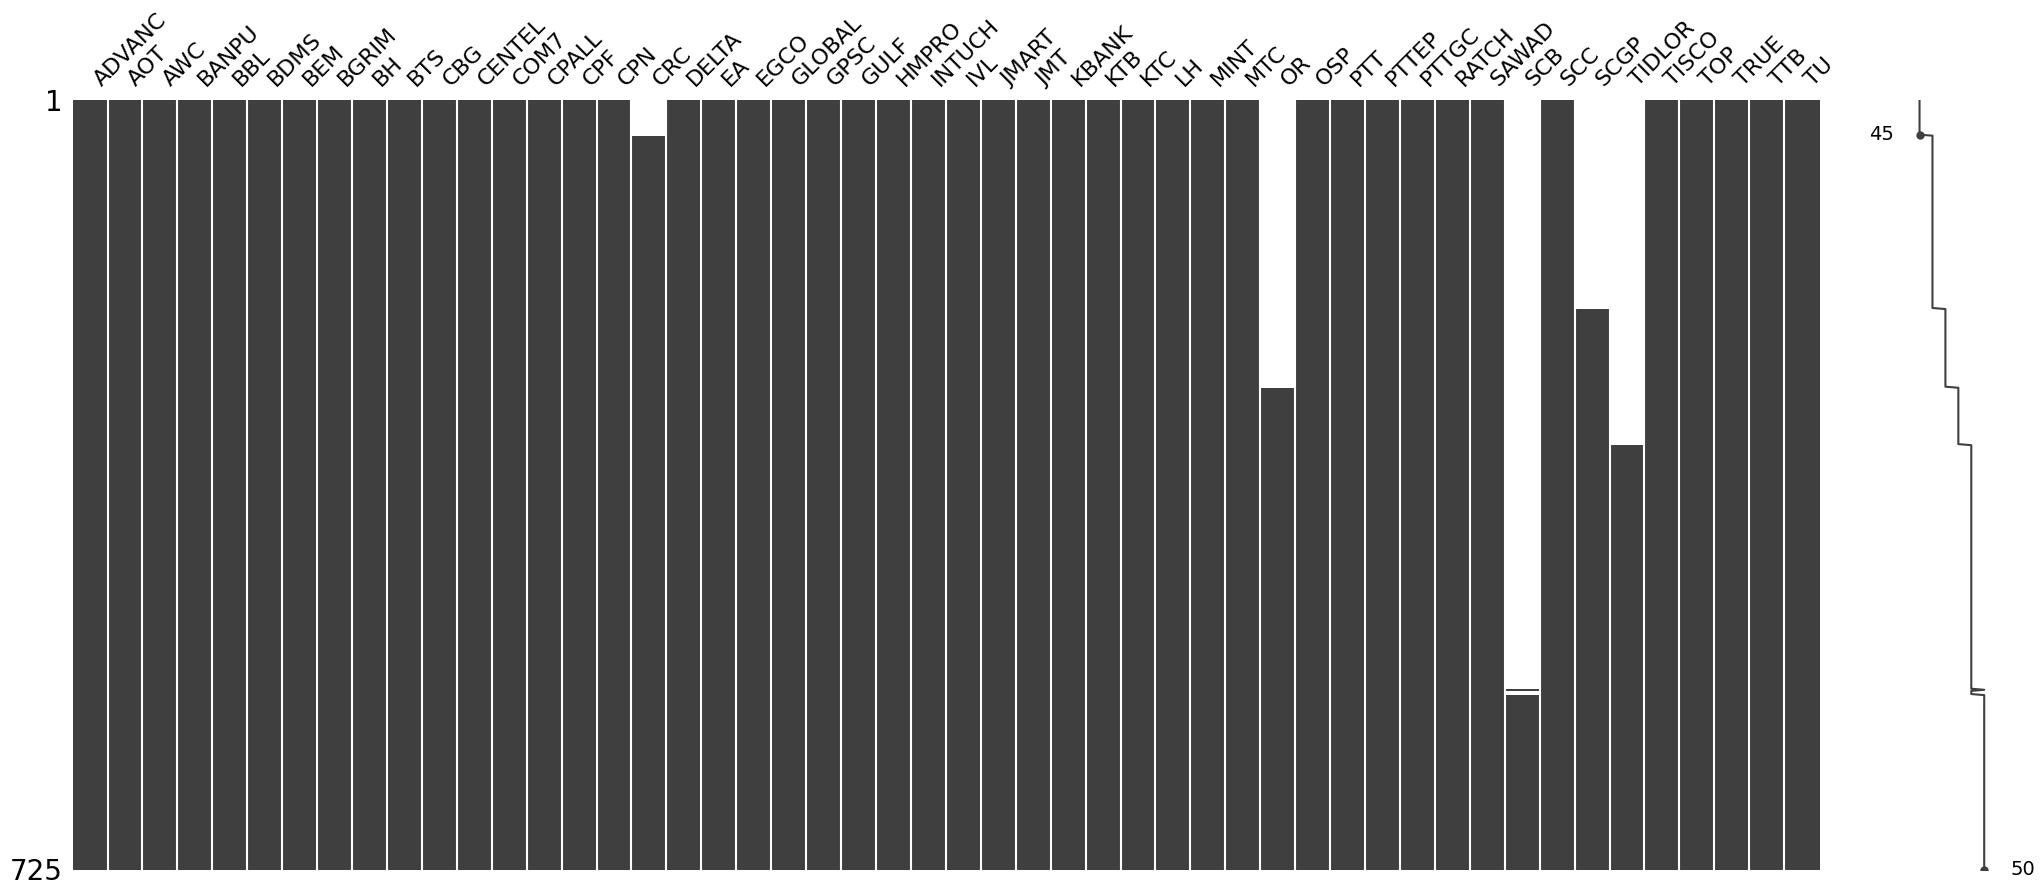

In [9]:
import missingno as msno
msno.matrix(df_price)

In [10]:
df_price.reset_index(inplace=True)

In [11]:
df_price = df_price.drop(['SCB'], axis=1)

In [12]:
def create_price_pair(df, stock1, stock2, TRADING_PERIOD=None):
    df_price_pair = df[['date', stock1, stock2]].copy()
    #fill missing value
    df_price_pair = df_price_pair.fillna(method='ffill')
    #drop row with missing value
    df_price_pair = df_price_pair.dropna()
    if TRADING_PERIOD:
        df_train = df_price_pair.iloc[:-TRADING_PERIOD].copy()
        df_test = df_price_pair.iloc[-TRADING_PERIOD:].copy()
    else:
        df_train = df_price_pair.copy()
        df_test = df_price_pair.iloc[:int(len(df_price_pair)*0.1)].copy()   #10% of data for testing
   
    #calculate spread
    beta = OLS(df_train[stock1], df_train[stock2]).fit().params[0] #first stock is y, second stock is x
    df_train['spread'] = df_train[stock1] - beta * df_train[stock2]
    df_train['zscore'] = (df_train['spread'] - df_train['spread'].mean()) / df_train['spread'].std()  
     
    df_test['spread'] = df_test[stock1] - beta * df_test[stock2]
    df_test['zscore'] = (df_test['spread'] - df_train['spread'].mean()) / df_train['spread'].std()
    return df_train, df_test, beta

In [13]:
df_test, _, _ = create_price_pair(df_price, 'ADVANC', 'AOT')
df_test

symbol,date,ADVANC,AOT,spread,zscore
0,2020-01-02,191.461044,74.814011,-17.563540,-0.899373
1,2020-01-03,189.704483,73.571259,-15.847948,-0.816062
2,2020-01-06,190.582764,71.831390,-10.108609,-0.537354
3,2020-01-07,195.852325,73.322701,-9.005653,-0.483793
4,2020-01-08,193.217529,72.577049,-9.557157,-0.510575
...,...,...,...,...,...
720,2022-12-26,188.123428,73.750000,-17.928392,-0.917091
721,2022-12-27,189.593140,75.500000,-21.348046,-1.083153
722,2022-12-28,190.083054,75.500000,-20.858132,-1.059362
723,2022-12-29,192.042664,76.250000,-20.993965,-1.065958


In [14]:
test = ts.coint(df_test['ADVANC'], df_test['AOT'])
test

(-1.8176859740069222,
 0.6210922602104854,
 array([-3.9116309 , -3.34458238, -3.0503132 ]))

In [15]:
#cointegration test all pairs of stocks
stock_list = df_price.columns[1:]
df_result = pd.DataFrame()
for i in range(df_price.shape[1]-1):
    for j in range(i+1, df_price.shape[1]-1):
        stock1 = stock_list[i]
        stock2 = stock_list[j]
        
        #cointegration test
        try: 
            df, _ = create_price_pair(df_price, stock1, stock2)
            result = ts.coint(df[stock2], df[stock1])
            df_result = pd.concat([df_result, pd.DataFrame({'stock1':stock1, 'stock2':stock2, 'coint_t':result[0], 'pvalue':result[1]}, index=[0])])
        except Exception as e:
            print(e)
        
df_result

too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack (expected 2)
too many values to unpack

""


In [16]:
#rank pairs by pvalue
df_result = df_result.sort_values(by='pvalue')
df_result.head(20)

KeyError: 'pvalue'

In [ ]:
df_train, df_test = create_price_pair(df_price, 'LH', 'TTB', 100)
df_comb = pd.concat([df_train, df_test]).sort_values(by='date')
df_comb

symbol,date,LH,TTB,spread,zscore
0,2020-01-02,7.926671,1.455010,-2.037100,-4.057612
1,2020-01-03,8.083634,1.446350,-1.820829,-3.637505
2,2020-01-06,7.848189,1.377063,-1.581809,-3.173208
3,2020-01-07,8.005153,1.377063,-1.424845,-2.868305
4,2020-01-08,7.926671,1.333759,-1.206786,-2.444723
...,...,...,...,...,...
720,2022-12-26,9.490886,1.310290,0.518147,0.905965
721,2022-12-27,9.587239,1.319924,0.548526,0.964975
722,2022-12-28,9.635417,1.329559,0.530727,0.930401
723,2022-12-29,9.731771,1.339193,0.561106,0.989411


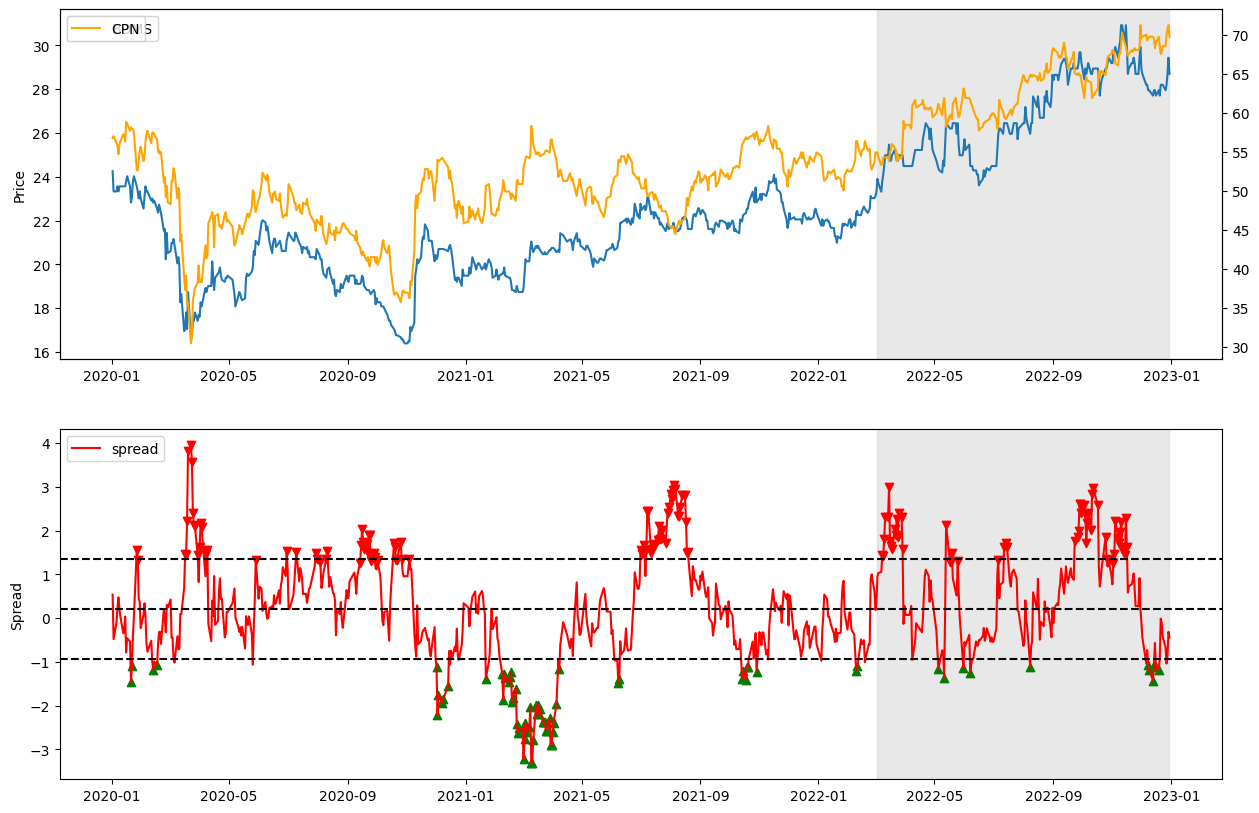

In [ ]:
# plot selected pair and hilight cointegration region, and mark buy/sell signal
SD_MULTIPLIER = 1
def plot_coint(df, stock1, stock2, TRADING_PERIOD=None):
    df_train, df_test, _ = create_price_pair(df, stock1, stock2, TRADING_PERIOD)
    df_price_pair = pd.concat([df_train, df_test]).sort_values(by='date')
    #plot price and spread in 2 subplots
    fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    #plot prices of 2 stocks using separate y-axis
    ax_twin = ax.twinx()
    ax.plot(df_price_pair['date'], df_price_pair[stock1], label=stock1)
    ax_twin.plot(df_price_pair['date'], df_price_pair[stock2], label=stock2, color='orange')
    ax.set_ylabel('Price')
    #color region for test period
    test_start = df_test['date'].iloc[0]
    test_end = df_test['date'].iloc[-1]
    ax.axvspan(test_start, test_end, alpha=0.5, color='lightgrey')
    ax.set_ylabel('Price')
    ax.legend()
    ax_twin.legend()
    #plot spread
    ax2.plot(df_price_pair['date'], df_price_pair['spread'], color='red', label='spread')
    ax2.set_ylabel('Spread')
    ax2.legend()
    #plot cointegration region
    ax2.axhline(y=np.mean(df_price_pair['spread']), color='black', linestyle='--')
    ax2.axhline(y=np.mean(df_price_pair['spread'])+np.std(df_price_pair['spread']), color='black', linestyle='--')
    ax2.axhline(y=np.mean(df_price_pair['spread'])-np.std(df_price_pair['spread']), color='black', linestyle='--')
    ax2.axvspan(test_start, test_end, alpha=0.5, color='lightgrey')
    #mark buy/sell signal using zscore
    #plot with scatter
    buy = df_price_pair[df_price_pair['zscore'] < -SD_MULTIPLIER]
    sell = df_price_pair[df_price_pair['zscore'] > SD_MULTIPLIER]
    ax2.scatter(buy['date'], buy['spread'], color='green', marker='^', label='buy')
    ax2.scatter(sell['date'], sell['spread'], color='red', marker='v', label='sell')
    plt.show()

plot_coint(df_price, 'BDMS', 'CPN', TRADING_PERIOD=200)

In [ ]:
# create backtest class
# largely inspired on https://bsic.it/pairs-trading-building-a-backtesting-environment-with-python/
class Backtest:
    def __init__(self, df, stock1, stock2, ENTRY_SD, EXIT_SD, CUTLOSS_SD, TRADING_PERIOD, INITIAL_CAPITAL):
        self.df = df
        self.stock1 = stock1
        self.stock2 = stock2
        self.ENTRY_SD = ENTRY_SD
        self.EXIT_SD = EXIT_SD
        self.CUTLOSS_SD = CUTLOSS_SD
        self.TRADING_PERIOD = TRADING_PERIOD
        self.INITIAL_CAPITAL = INITIAL_CAPITAL

    def gen_signal(self):
        df_train, df_test, beta = create_price_pair(self.df, self.stock1, self.stock2, self.TRADING_PERIOD)
        print('beta: ', beta)
        self.df = pd.concat([df_train, df_test]).sort_values(by='date')
        self.df['signal'] = 0
        self.df['signal'] = np.where(self.df['zscore'] < -self.ENTRY_SD, 1, self.df['signal'])
        self.df['signal'] = np.where(self.df['zscore'] > self.ENTRY_SD, -1, self.df['signal'])
        # checking signal if signal is 1 then close position when spread is above mean
        # if signal is -1 then close position when spread is below mean
        #enter_long_spread, when zscore cross down below -ENTRY_SD
        self.df['enter_long_spread'] = self._cross_over(self.df['zscore'], -self.ENTRY_SD, cross_up=False)
        self.df['enter_short_spread'] = self._cross_over(self.df['zscore'], self.ENTRY_SD, cross_up=True)
        self.df['close_long_spread'] = self._cross_over(self.df['zscore'], self.EXIT_SD, cross_up=True)
        self.df['close_short_spread'] = self._cross_over(self.df['zscore'], -self.EXIT_SD, cross_up=False)
        self.df['cutloss_long_spread'] = self._cross_over(self.df['zscore'], self.CUTLOSS_SD, cross_up=True)
        self.df['cutloss_short_spread'] = self._cross_over(self.df['zscore'], -self.CUTLOSS_SD, cross_up=False)

        # initialize position
        self.df['position'] = 0
        self.df[self.stock1+'_position'] = 0
        self.df[self.stock2+'_position'] = 0
        self.df['entry_spread'] = np.NaN
        self.df['exit_spread'] = np.NaN
        self.df['profit_stock1'] = 0
        self.df['profit_stock2'] = 0
        self.df['ugl'] = 0
        self.df['profit'] = 0
        self.df['capital'] = np.NaN # or market value
        # loop through all rows
        open_position = 0
        self.df.loc[0, 'capital'] = self.INITIAL_CAPITAL
        df_txn = pd.DataFrame()
        for i in range(1, self.df.shape[0]):
            # if position is 0 then check signal
            stock1_price = self.df[self.stock1][i]
            stock2_price = self.df[self.stock2][i]
            
            if open_position == 0: 
                capital = self.df.loc[i-1, 'capital']
                if self.df['enter_long_spread'][i]:
                    open_position = 1
                    self.df.loc[i, 'position'] = open_position
                    #record entry price
                    self.df.loc[i, 'entry_spread'] = self.df['spread'][i]
                    entry_spread = self.df['spread'][i]
                    stock1_cost = stock1_price
                    stock2_cost = stock2_price
                    #calculate number of shares, use all capital to buy stock1 and stock2 using beta, assuming that short selling is allowed and have to put up margin = 100%
                    #capital = n * stock1_price + m * stock2_price and m = n * beta
                    #capital = n * stock1_price + n * beta * stock2_price
                    #capital = n * (stock1_price + beta * stock2_price)
                    n = capital / (stock1_price + beta * stock2_price)
                    m = n * beta
                    self.df.loc[i, self.stock1+'_position'] = n
                    self.df.loc[i, self.stock2+'_position'] = -m
                    self.df.loc[i, 'capital'] = n*stock1_price + m*stock2_price
                    txn = {'date': self.df['date'][i], 'position_type': 'long', 'entry_spread': entry_spread, 
                            self.stock1: self.df[self.stock1][i], self.stock2: self.df[self.stock2][i],
                            self.stock1+'_shares': n, self.stock2+'_shares': -m, 'capital': n*stock1_price + m*stock2_price}
                    new_txn = pd.DataFrame(txn, index=[0])
                    df_txn = pd.concat([df_txn, new_txn], ignore_index=True)

                elif self.df['enter_short_spread'][i]: 
                    open_position = -1
                    self.df.loc[i, 'position'] = open_position
                    self.df.loc[i, 'entry_spread'] = -self.df['spread'][i]  
                    entry_spread = self.df['spread'][i]
                    stock1_cost = stock1_price
                    stock2_cost = stock2_price
                    m = capital / (stock1_price * beta + stock2_price)
                    n = m * beta
                    self.df.loc[i, self.stock1+'_position'] = -n
                    self.df.loc[i, self.stock2+'_position'] = m
                    self.df.loc[i, 'capital'] = n*stock1_price + m*stock2_price
                    txn = {'date': self.df['date'][i], 'position_type': 'short', 'entry_spread': entry_spread, 
                            self.stock1: self.df[self.stock1][i], self.stock2: self.df[self.stock2][i],
                            self.stock1+'_shares': -n, self.stock2+'_shares': m, 'capital': n*stock1_price + m*stock2_price}
                    new_txn = pd.DataFrame(txn, index=[0])
                    df_txn = pd.concat([df_txn, new_txn], ignore_index=True)
                else:
                    self.df.loc[i, 'capital'] = capital

            # if already have position then check exit signal
            else:
                # if long spread position and exit signal is true then close position
                if (open_position == 1) & (self.df['close_long_spread'][i]):
                    self.df.loc[i, 'exit_spread'] = -self.df['spread'][i]
                    self.df.loc[i, 'profit'] = self.df['spread'][i] - entry_spread
                    open_position = 0                    
                    txn = {'date': self.df['date'][i], 'position_type': 'exit long', 'exit_spread': self.df['spread'][i]}
                    new_txn = pd.DataFrame(txn, index=[0])
                    df_txn = pd.concat([df_txn, new_txn], ignore_index=True)

                elif (open_position == -1) & (self.df['close_short_spread'][i]):
                    self.df.loc[i, 'exit_spread'] = self.df['spread'][i]
                    self.df.loc[i, 'profit'] = entry_spread - self.df['spread'][i]
                    open_position = 0   
                    txn = {'date': self.df['date'][i], 'position_type': 'exit short', 'exit_spread': self.df['spread'][i]}
                    new_txn = pd.DataFrame(txn, index=[0])
                    df_txn = pd.concat([df_txn, new_txn], ignore_index=True)
                    
                elif (open_position == 1) & (self.df['cutloss_long_spread'][i]):
                    self.df.loc[i, 'exit_spread'] = -self.df['spread'][i]
                    self.df.loc[i, 'profit'] = self.df['spread'][i] - entry_spread
                    open_position = 0   
                    txn = {'date': self.df['date'][i], 'position_type': 'cutloss long', 'exit_spread': self.df['spread'][i]}
                    new_txn = pd.DataFrame(txn, index=[0])
                    df_txn = pd.concat([df_txn, new_txn], ignore_index=True)
                elif (open_position == -1) & (self.df['cutloss_short_spread'][i]):
                    self.df.loc[i, 'exit_spread'] = self.df['spread'][i]
                    self.df.loc[i, 'profit'] = entry_spread - self.df['spread'][i]
                    open_position = 0   
                    txn = {'date': self.df['date'][i], 'position_type': 'cutloss short', 'exit_spread': self.df['spread'][i]}
                    new_txn = pd.DataFrame(txn, index=[0])
                    df_txn = pd.concat([df_txn, new_txn], ignore_index=True)

                if open_position == 0:
                    self.df.loc[i, 'position'] = 0
                    entry_spread = np.NaN
                    self.df.loc[i, 'capital'] = self.df['capital'][i-1] + self.df['position'][i-1] * self.df['spread'].pct_change()[i]
                else:
                    # if no exit signal then keep position
                    self.df.loc[i, 'position'] = open_position
                    self.df.loc[i, self.stock1+'_position'] = self.df[self.stock1+'_position'][i-1]
                    self.df.loc[i, self.stock2+'_position'] = self.df[self.stock2+'_position'][i-1]
                    #mark to market
                    self.df.loc[i, 'ugl'] = (stock1_price - stock1_cost) * open_position * n - (stock2_price - stock2_cost) * open_position * m
                    self.df.loc[i, 'capital'] = self.df['capital'][i-1] +  self.df['ugl'].diff()[i]


            self.df_txn = df_txn
    # cross over function, accept series of zscore and SD
    def _cross_over(self, zscore: pd.Series, SD: float, cross_up: bool = True) -> pd.Series:
        if cross_up:
            # return (zscore > SD) & (zscore.shift(1) < SD)
            return (zscore > SD)
        else:
            # return (zscore < SD) & (zscore.shift(1) > SD)
            return (zscore < SD)

In [ ]:
ENTRY_SD = 1
EXIT_SD = 0
CUTLOSS_SD = 2
stock1 = 'LH'
stock2 = 'TTB'
TRADING_PERIOD = 200
INITIAL_CAPITAL = 100
pairs = Backtest(df_price, stock1, stock2, ENTRY_SD, EXIT_SD, CUTLOSS_SD, TRADING_PERIOD, INITIAL_CAPITAL)

In [ ]:
pairs.gen_signal()
df_plot = pairs.df
df_plot['is_just_long'] = (df_plot['position'] == 1) & (df_plot['position'].shift(1) == 0)
df_plot['is_just_short'] = (df_plot['position'] == -1) & (df_plot['position'].shift(1) == 0)
df_plot['is_just_exit_long'] = (df_plot['position'] == 0) & (df_plot['position'].shift(1) == 1)
df_plot['is_just_exit_short'] = (df_plot['position'] == 0) & (df_plot['position'].shift(1) == -1)

beta:  6.819324014286937


In [ ]:
pd.set_option('display.max_columns', 25)
df_save = df_plot.loc[:, ['date', 'LH', 'TTB', 'spread','LH_position', 'TTB_position', 'capital', 'ugl']]

In [ ]:
df_plot[df_plot['is_just_exit_short'] == True].head(10).T

,62,209,218,427,466,658,678
symbol,,,,,,,
date,2020-03-31,2020-11-10,2020-11-23,2021-10-07,2021-12-03,2022-09-22,2022-10-25
LH,5.258286,6.136637,6.77587,7.294789,7.659529,8.43099,8.720053
TTB,0.762148,0.912822,1.028033,1.068436,1.114489,1.233214,1.281386
spread,0.06095,-0.088192,-0.234617,0.008779,0.059467,0.021306,-0.018135
zscore,-0.007019,-0.279909,-0.547828,-0.102478,-0.009734,-0.079557,-0.151724
signal,0,0,0,0,0,0,0
enter_long_spread,False,False,False,False,False,False,False
enter_short_spread,False,False,False,False,False,False,False
close_long_spread,False,False,False,False,False,False,False


In [ ]:
pairs.df_txn

,date,position_type,entry_spread,LH,TTB,LH_shares,TTB_shares,capital,exit_spread
0,2020-01-03,long,-1.779492,8.083634,1.446350,12.054394,-1.767682,100.0,NaN
1,2020-02-26,exit long,NaN,NaN,NaN,NaN,NaN,NaN,0.116027
2,2020-03-13,short,0.787905,5.689937,0.718844,NaN,NaN,NaN,NaN
3,2020-03-31,exit short,NaN,NaN,NaN,NaN,NaN,NaN,0.060950
4,2020-05-20,long,-0.556087,5.729178,0.921685,NaN,NaN,NaN,NaN
5,2020-07-01,exit long,NaN,NaN,NaN,NaN,NaN,NaN,0.070327
6,2020-08-11,short,0.652083,6.393430,0.841923,NaN,NaN,NaN,NaN
7,2020-11-10,exit short,NaN,NaN,NaN,NaN,NaN,NaN,-0.088192
8,2020-11-18,short,0.682754,6.605408,0.868510,NaN,NaN,NaN,NaN
9,2020-11-23,exit short,NaN,NaN,NaN,NaN,NaN,NaN,-0.234617


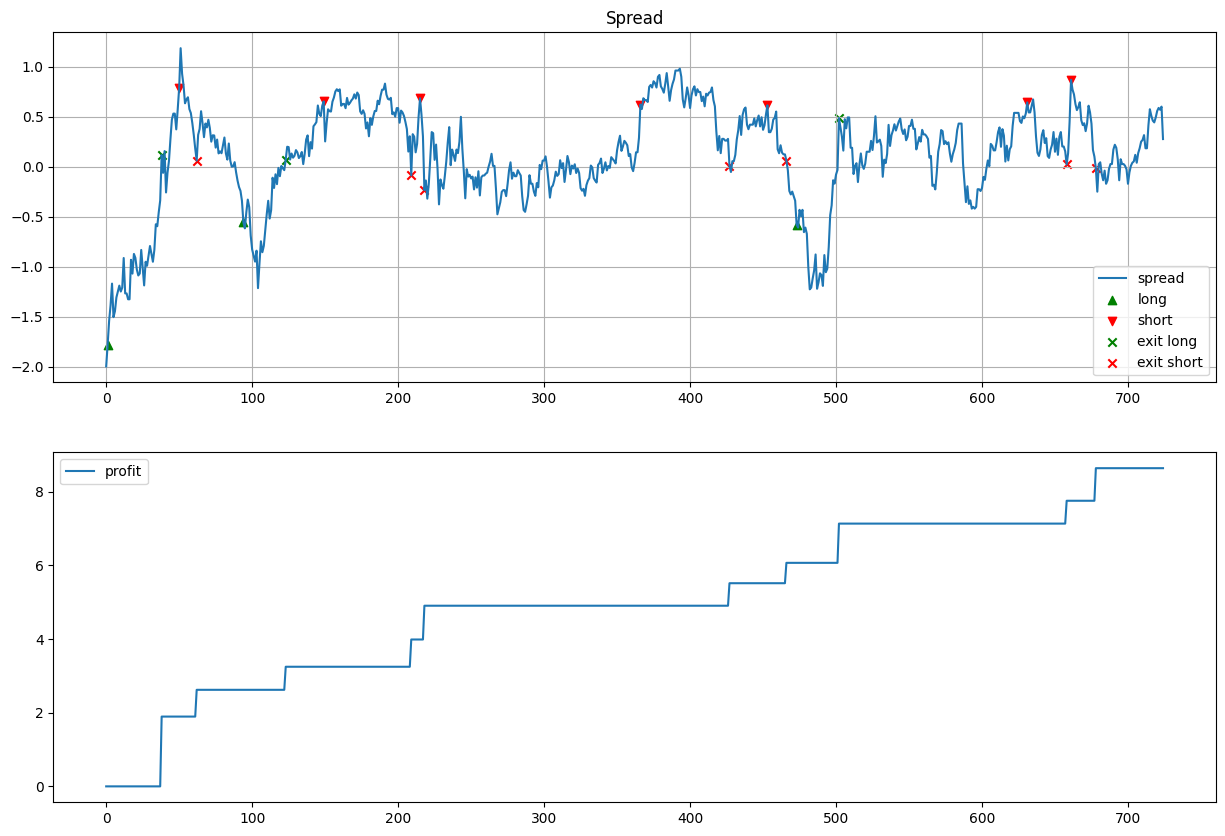

In [ ]:
#plot backtest result
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(df_plot['spread'], label='spread')
ax[0].scatter(df_plot[df_plot['is_just_long'] == 1].index, df_plot[df_plot['is_just_long'] == 1]['spread'], label='long', marker='^', color='g')
ax[0].scatter(df_plot[df_plot['is_just_short'] == 1].index, df_plot[df_plot['is_just_short'] == 1]['spread'], label='short', marker='v', color='r')
ax[0].scatter(df_plot[df_plot['is_just_exit_long'] == 1].index, df_plot[df_plot['is_just_exit_long'] == 1]['spread'], label='exit long', marker='x', color='g')
ax[0].scatter(df_plot[df_plot['is_just_exit_short'] == 1].index, df_plot[df_plot['is_just_exit_short'] == 1]['spread'], label='exit short', marker='x', color='r')
ax[0].legend()
ax[0].set_title('Spread')
ax[0].grid()

#ax[1] for accumulated profit
ax[1].plot(df_plot['profit'].cumsum(), label='profit')
ax[1].legend()


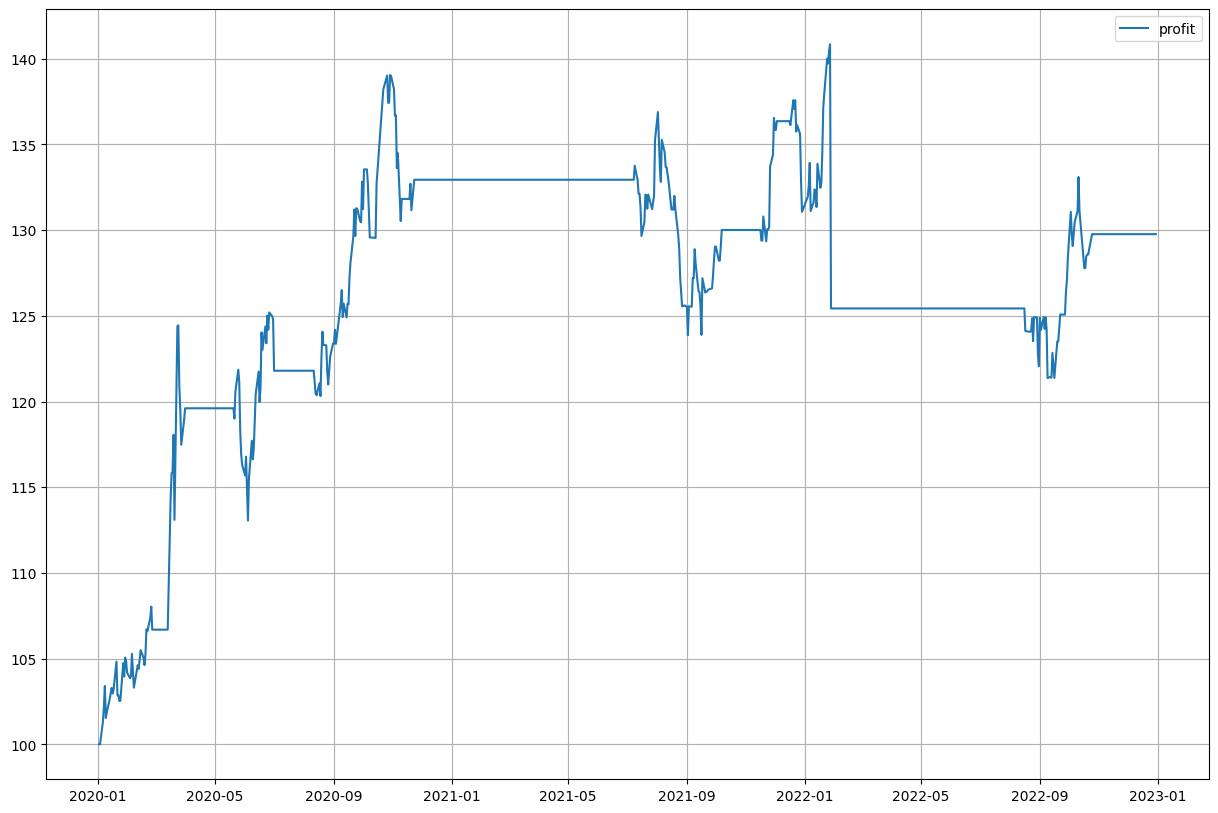

In [ ]:
#plot capital
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(df_save['date'], df_save['capital'], label='profit')
ax.legend()
ax.grid()

